# Neural Networks Skills Session
*Notebook for my skills session on neural networks on 2024-03-01*

The aims for this skills session are to:
- Give you an idea of what a neural network actually is
- Show you what the caveats are (they aren't actually magic)
- Get you training a neural network to emulate simple stellar evolution data


Get started with some imports:

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1 Neural network basics
Neural networks are a type of machine learning model which learn to reproduce patterns from the data they are trained on.

They consist of a series of interconnected ***layers*** which are populated by one or more ***neurons***. Inputs are passed through a series of neurons before a prediction is made on the corresponding output:

![](https://miro.medium.com/v2/resize:fit:805/0*Y4xTJQNCU3uvk0up.png)

Seeing diagrams like this might be what has stopped you from looking any further into learning how to train your own neural networks, but I promise it really isn't as bad as it looks!

## 1.1 What are neurons?
Each node in the image above is a singe neuron in an example network.

Let's take a look at what a neuron looks like:

![](https://www.nickmccullum.com/images/python-deep-learning/understanding-neurons-deep-learning/activation-function.png)

To get an output $y$ from some input $x$, we just apply a linear transformation of the form
\begin{equation}
  y = f(wx+b),
\end{equation}
where $w$ is a ***weight*** term, $b$ is a ***bias*** term. ($f(\cdot)$ is the ***activation function***, we'll come back to this later!)

A neural network consisting of a single layer, with a single neuron, and a linear activation function (i.e $f(a) = a$) is just optimising a linear fit by tuning the neuron weights and biases.

Let's see how this looks:

In [ ]:
def linear_fit(weight, bias):
  ##### generate inputs #####
  x = np.random.rand(1000)

  ##### generate outputs #####
  y = weight*x + bias

  ##### create tensorflow model #####
  tf.keras.backend.clear_session()
  linear_model = tf.keras.Sequential()#instantiate model

  linear_model.add(tf.keras.Input(1,))#input layer

  linear_model.add(tf.keras.layers.Dense(units=1, activation="linear",))#single dense layer, single neuron, linear activation

  linear_model.compile(loss='mse')

  linear_model.fit(x,y,epochs=50,batch_size=10, verbose=0)

  ##### print neuron weights and biases #####
  print("linear model weight = " + str(linear_model.layers[0].get_weights()[0]))
  print("linear model bias = " + str(linear_model.layers[0].get_weights()[1]))

weight= 1 #<--- input value here (between -1 and 1 please!)
bias = -1 #<--- input value here (between -1 and 1 please!)

linear_fit(weight, bias)

In many cases, we'll have more than one input into our networks ($\textbf{x}$).

Then our single neuron takes this form:

***NEURON IMAGE HERE, MANY INPUTS***

And our linear transformation just becomes
\begin{equation}
  y = f(\textbf{w} \cdot \textbf{x} +b),
\end{equation}
where $\textbf{w}$ contains multiple weights.

Let's see how our simple one neuron network copes with multiple inputs:


In [ ]:
def linear_fit(weights, bias):
  ##### generate inputs and outputs #####
  dataset_size=1000
  inputs={}
  output=np.full(dataset_size, bias)

  for idx in range(len(weights)):
    x = np.random.rand(dataset_size)
    inputs[f'x{idx}'] = x
    output += weights[idx]*x

  ##### create tensorflow model #####
  tf.keras.backend.clear_session()
  linear_model = tf.keras.Sequential()#instantiate model

  linear_model.add(tf.keras.Input(len(weights),))#input layer

  linear_model.add(tf.keras.layers.Dense(units=1, activation="linear",))#single dense layer, single neuron, linear activation

  linear_model.compile(loss='mse')

  linear_model.fit(np.column_stack([inputs[f'x{idx}'] for idx in range(len(weights))]),output,epochs=100,batch_size=10, verbose=0)

  ##### print neuron weights and biases #####
  print("linear model weights = " + str(linear_model.layers[0].get_weights()[0]))
  print("linear model bias = " + str(linear_model.layers[0].get_weights()[1]))

weights= [0.5,0.8,-0.4,-0.2] #<--- input values here (between -1 and 1 please!)
bias = 0.3 #<--- input value here (between -1 and 1 please!)

linear_fit(weights, bias)

This looks good so far, but what if we want to start building up our network with more neurons to fit more complex functions?

Let's go back to our model from the start, linking a single input $x$ to a single output $y$, but this time pass $x$ through three neurons, $n_1, n_2,$ and $n_3$, instead of just one.

Given we know now what each neuron is doing, it's easy to construct a function linking $x$ to $y$:

\begin{equation}
y = f(w_3f(w_2f(w_1x+b_1)+b_2)+b_3).
\end{equation}

Now we know what is happening within each neuron, let's move on to the activation function.

## 1.2 Activation functions
Activation functions are used to introduce non-linearities into neural networks to allow us to fit more complex functions.

Before, we just used a linear activation function of the form
\begin{equation}
f(\textbf{w}\cdot\textbf{x} + b) = \alpha(\textbf{w}\cdot\textbf{x} + b) + \beta,
\end{equation}
where $(\alpha, \beta) = (1,0)$.

It turns out linear activation functions aren't a good choice if we're looking for non-linearity!

If we take our equation for a series of neurons from before:

\begin{equation}
y = \alpha w_3(\alpha w_2(\alpha w_1x + b_3 + \beta) + b_ 2 + \beta) + b_3 + \beta,
\end{equation}

Given that our neuron weights and biases, $w_n$ and $b_n$, and our linear activation function terms, $\alpha$ and $\beta$, are all constants, this equation for our fit collapses down to

\begin{equation}
y = \alpha^3 w_3 w_2 w_1 x + \gamma,
\end{equation}

where $\gamma$ is a constant. It doesn't matter how much we tune our $w_n$ terms here, we're stuck with a linear fit!

Due to its computational efficiency, popular choice is the Rectified Linear Unit (ReLU) function:
\begin{equation}
f(x) = \textrm{max}(0,x),
\end{equation}
Plotting this, we get:

Text(0.5, 1.0, 'ReLU activation function')

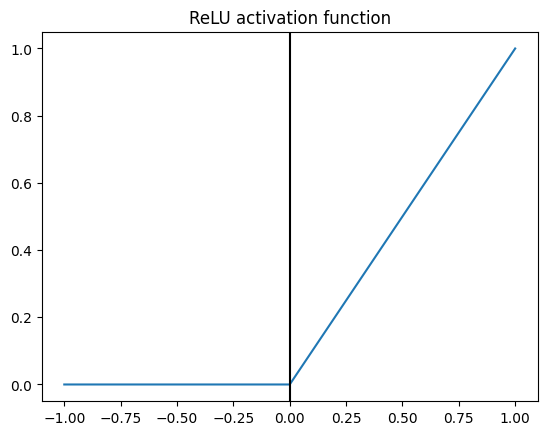

In [4]:
def rectified_linear_unit(x):
  return max(0.0, x)

x = np.linspace(-1,1,1000)
y = [rectified_linear_unit(x_val) for x_val in x]
plt.plot(x,y)
plt.axvline(0, color='black')
plt.title('ReLU activation function')
plt.show()

You might be thinking that this still seems very close to a linear function.

However, ReLU doesn't stick to the condition of a linear function that requires
\begin{equation}
f(x) + f(y) = f(x+y),
\end{equation}
because for ReLU $f(-1) + f(1) \neq f(0)$.

This means we avoid the function for our series of neurons collapsing down to just a linear fit, and we have non-linearity!

Now, by increasing the number of layers in our network, and the number of neurons per layer, we're able to effectively reproduce complex functions present in a dataset used for training.

For the rest of this notebook we'll stick to just using ReLU, but I'll show you a couple of other activation functions here:

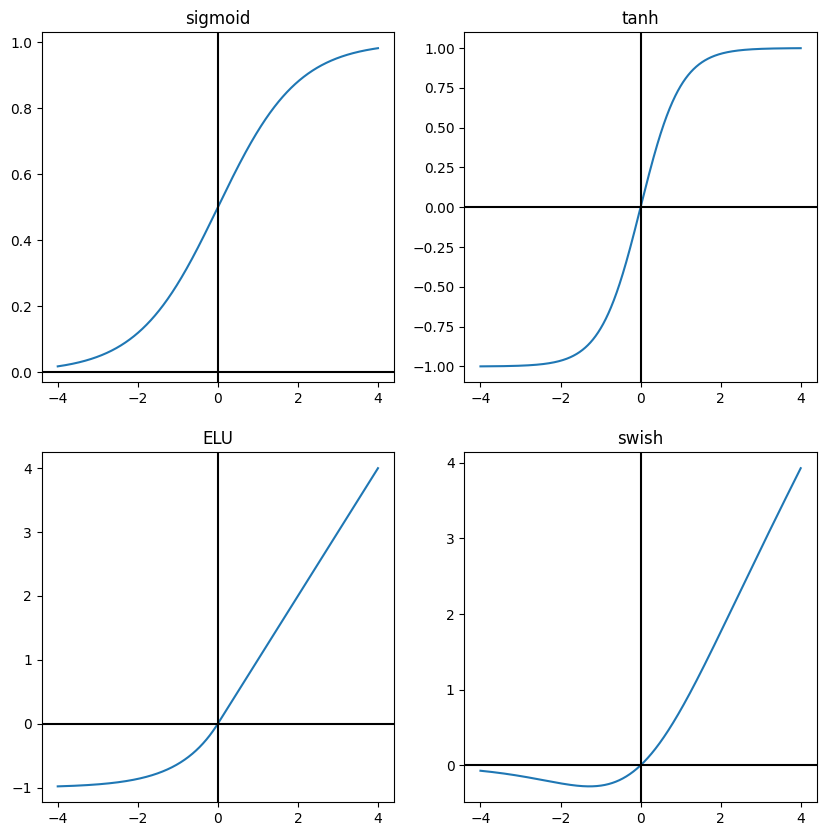

In [24]:
x = np.linspace(-4,4,1000)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(10,10))

def sigmoid(x):
  return 1/(1+(np.e**-x))

y = [sigmoid(x_val) for x_val in x]

ax1.plot(x,y)
ax1.axvline(0, color='black')
ax1.axhline(0, color='black')
ax1.set_title('sigmoid')

def tanh(x):
  return ((np.e**x)-(np.e**-x))/((np.e**x)+(np.e**-x))

y = [tanh(x_val) for x_val in x]

ax2.plot(x,y)
ax2.axvline(0, color='black')
ax2.axhline(0, color='black')
ax2.set_title('tanh')

def elu(x):
  if x >= 0:
    y = x
  else:
    y = (np.e**x)-1
  return y

y = [elu(x_val) for x_val in x]

ax3.plot(x,y)
ax3.axvline(0, color='black')
ax3.axhline(0, color='black')
ax3.set_title('ELU')

def swish(x):
  return x*sigmoid(x)

y = [swish(x_val) for x_val in x]

ax4.plot(x,y)
ax4.axvline(0, color='black')
ax4.axhline(0, color='black')
ax4.set_title('swish')

plt.show()

## 1.3 Loss functions
The last part of a basic neural network we need to learn about is the ***loss function*** - this is how our neural network determines how well it is fitting the data.

For a every point in our dataset of $N$ points, each with an $x$ and $y$ value, we show our network the input $x$ and it makes a prediction $\hat{y}$.

A common choice is to take the Mean Squared Error (MSE), averaged over all $N$ points:
\begin{equation}
\textrm{MSE} = \frac{1}{N} \sum_{y=i}^{N} (y_i-\hat{y}_i)^2
\end{equation}

During training, our network tunes the neuron weights and biases in a way that decreases the MSE over the dataset.

I turned off the in-training network printout from the cells for our single neuron, but lets run them again with the printout enabled (setting verbose=1 in model.fit) to see what we get:

In [ ]:
def linear_fit(weight, bias):
  ##### generate inputs #####
  x = np.random.rand(1000)

  ##### generate outputs #####
  y = weight*x + bias

  ##### create tensorflow model #####
  tf.keras.backend.clear_session()
  linear_model = tf.keras.Sequential()#instantiate model

  linear_model.add(tf.keras.Input(1,))#input layer

  linear_model.add(tf.keras.layers.Dense(units=1, activation="linear",))#single dense layer, single neuron, linear activation

  linear_model.compile(loss='mse')# <- here's where we define our loss function!

  linear_model.fit(x,y,epochs=50,batch_size=10, verbose=1)

  ##### print neuron weights and biases #####
  print("linear model weight = " + str(linear_model.layers[0].get_weights()[0]))
  print("linear model bias = " + str(linear_model.layers[0].get_weights()[1]))

weight= 0.5 #<--- input value here (between -1 and 1 please!)
bias = 0.8 #<--- input value here (between -1 and 1 please!)

linear_fit(weight, bias)

Hopefully, you should get a series of readouts that look something like this:

> Epoch 1/50\
100/100 [==============================] - 1s 2ms/step - loss: 2.2699\
Epoch 2/50\
100/100 [==============================] - 0s 2ms/step - loss: 1.8381\
Epoch 3/50\
100/100 [==============================] - 0s 1ms/step - loss: 1.4577,

with the 'loss' value decreasing each epoch (each pass through the dataset). This is your neural network learning!

# 2 Neural Network Caveats
Now we know what's going on inside a neural network, let's go over the balancing act between under and overfitting, and the dangers of extrapolation!


## 2.1 Underfitting
Typically, underfitting is an indication that we aren't using a neural network architecture that is complex enough to fit our target function properly.

Let's say we want to train a neural network to reproduce the function
\begin{equation}
y = \textrm{sin}(x)
\end{equation}
And we take some samples from this function to train our simple one neuron network:

In [ ]:
def sin_fit(layers, neurons_per_layer):
  ##### generate inputs #####
  x_train = np.random.uniform(low=-3*np.pi, high=3*np.pi, size=1000)

  ##### generate outputs #####
  y_train = np.sin(x_train)

  ##### create tensorflow model #####
  tf.keras.backend.clear_session()
  sin_model = tf.keras.Sequential()#instantiate model

  sin_model.add(tf.keras.Input(1,))#input layer

  for layer in range(layers):
    sin_model.add(tf.keras.layers.Dense(units=int(neurons_per_layer), activation="relu",))

  sin_model.add(tf.keras.layers.Dense(1, activation="linear"))

  sin_model.compile(loss='mse')

  sin_model.fit(x_train,y_train,epochs=100,batch_size=10, verbose=1)

  return sin_model

layers = 2 #<--- input value here
neurons_per_layer = 1 #<--- input value here

sin_model = sin_fit(layers, neurons_per_layer)

Hopefully, your network should end up with an MSE loss score of $\sim0.5$

Now our network is trained, let's see how well it reproduces the function we used to generate our samples by testing it on some test data, again drawn from our function
\begin{equation}
y_{test} = \textrm{sin}(x_{test})
\end{equation}

In [ ]:
x_test = np.linspace(-3*np.pi, 3*np.pi,1000)
y_test = np.sin(x_test)

y_pred = np.array(sin_model(x_test)).flatten()

plt.figure(figsize=(20,5))
plt.scatter(x_test,y_test, label='test set')
plt.scatter(x_test,y_pred, label='predictions on test set')
plt.xlim(-3*np.pi, 3*np.pi)
plt.legend()
plt.title('Predictions')
plt.show()

Not good!

This network doesn't have enough neurons to solve this problem!

One layer with one neuron just isn't complex enough to fit anything other than a straight line (even with the non-linearity from our ReLU activation function), and has just learned that predicting $\hat{y} = 0$ for all $x$ is the best it can do to minimise the loss score.

Let's try again with a more complex network, what about 2 layers with 100 neurons?


In [ ]:
def sin_fit(layers, neurons_per_layer):
  ##### generate inputs #####
  x_train = np.random.uniform(low=-3*np.pi, high=3*np.pi, size=1000)

  ##### generate outputs #####
  y_train = np.sin(x_train)

  ##### create tensorflow model #####
  tf.keras.backend.clear_session()
  sin_model = tf.keras.Sequential()#instantiate model

  sin_model.add(tf.keras.Input(1,))#input layer

  for layer in range(layers):
    sin_model.add(tf.keras.layers.Dense(units=int(neurons_per_layer), activation="relu",))

  sin_model.add(tf.keras.layers.Dense(1, activation="linear"))

  sin_model.compile(loss='mse')

  sin_model.fit(x_train,y_train,epochs=100,batch_size=10, verbose=1)

  return sin_model

layers = 2 #<--- input value here
neurons_per_layer = 100 #<--- input value here

sin_model = sin_fit(layers, neurons_per_layer)

Your loss scores should be much better now! Again, let's see how we do when predicting test points:

In [ ]:
x_test = np.linspace(-3*np.pi, 3*np.pi,1000)
y_test = np.sin(x_test)

y_pred = np.array(sin_model(x_test)).flatten()

plt.figure(figsize=(20,5))
plt.scatter(x_test,y_test, label='test set')
plt.scatter(x_test,y_pred, label='predictions on test set')
plt.xlim(-3*np.pi, 3*np.pi)
plt.legend()
plt.title('Predictions')
plt.show()

Nice! We solved our underfitting problem by just making our neural network architecture more complex.

So why don't we just use extremely dense networks for every problem?

## 2.2 Overfitting
Overfitting is when a neural network starts to fit noise that is present in the training set instead of the general underlying function that we want it to learn.

Let's say we have some datapoints that roughly follow the trend $y = x$ but with some gaussian noise applied:

In [ ]:
np.random.seed(42)
x_train = np.linspace(-1,1,10)

y_train = x_train + np.random.normal(loc=0, scale=0.2, size=10)

plt.scatter(x_train,y_train, color='green', label='training set points')
plt.title('Training set')
plt.legend()
plt.show()

And following our success on the $y=\textrm{sin}(x)$ data we decide to use a network with 8 layers and 64 neurons per layer to avoid underfitting:

In [ ]:
def x_fit(x_train, y_train, layers, neurons_per_layer):
#### create tensorflow model #####
  tf.keras.backend.clear_session()

  x_model = tf.keras.Sequential()#instantiate model

  x_model.add(tf.keras.Input(1,))#input layer

  for layer in range(layers):
    x_model.add(tf.keras.layers.Dense(units=int(neurons_per_layer), activation="relu"))

  x_model.add(tf.keras.layers.Dense(1, activation="linear"))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)
  x_model.compile(loss='mse', optimizer=optimizer)

  x_model.fit(x_train,y_train,epochs=300,batch_size=10, verbose=1,shuffle=True)

  return x_model

layers = 8 #<--- input value here
neurons_per_layer = 64 #<--- input value here

x_model = x_fit(x_train, y_train, layers, neurons_per_layer)

Wow, these MSE loss scores (should) look amazing!

Let's test to see how our network has done by generating some test data following the same form, and see how the network's predictions look:

In [ ]:
x_test = np.linspace(-1,1,100)

y_test = x_test + np.random.normal(loc=0, scale=0.2, size=100)

y_pred = np.array(x_model(x_test)).flatten()

plt.scatter(x_test,y_test, label='test set')
plt.scatter(x_test,y_pred, color='orange', label='predictions on test set')
plt.legend()
plt.show()

That certainly doesn't look like $y=x$...

In fact, that form in the prediction line might look familiar - let's try plotting this over the training points we used to train the network to begin with:

In [ ]:
plt.plot(x_test,y_pred, c='orange', label='predictions on test set')
plt.scatter(x_train,y_train, c='green', label='training set')
plt.legend()
plt.show()

This network is too smart for its own good!

The loss function is all the neural network has to learn to inform its weight and bias tuning.

It was smart enough to learn a function far more complex than the $y=x$ we wanted it to learn, fit it to the datapoints in the training set including the noise, and achieve a loss score close to 0.

Let's see if we can rectify this by reducing our network complexity. Why not try going back to just 1 layer with 1 neuron.:

In [ ]:
def x_fit(x_train, y_train, layers, neurons_per_layer):
#### create tensorflow model #####
  tf.keras.backend.clear_session()

  x_model = tf.keras.Sequential()#instantiate model

  x_model.add(tf.keras.Input(1,))#input layer

  for layer in range(layers):
    x_model.add(tf.keras.layers.Dense(units=int(neurons_per_layer), activation="relu"))

  x_model.add(tf.keras.layers.Dense(1, activation="linear"))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)
  x_model.compile(loss='mse', optimizer=optimizer)

  x_model.fit(x_train,y_train,epochs=300,batch_size=10, verbose=1,shuffle=True)

  return x_model

layers = 1 #<--- input value here
neurons_per_layer = 1 #<--- input value here

x_model = x_fit(x_train, y_train, layers, neurons_per_layer)

In [ ]:
x_test = np.linspace(-1,1,100)

y_test = x_test + np.random.normal(loc=0, scale=0.2, size=100)

y_pred = np.array(x_model(x_test)).flatten()

plt.scatter(x_test,y_test, label='test set')
plt.scatter(x_test,y_pred, color='orange', label='predictions on test set')
plt.legend()
plt.show()

Smarter isn't always better!

It turns out that a simpler network was much better at finding a general function for this dataset that doesn't fit to the noise than our complex one.

Along with reducing network complexity, there are a couple of ways to detect and prevent overfitting while training a network:

- We can use a 'validation' set during training alongside our training set - points in our validation set aren't shown to the network while it updates weights and biases. By calculating loss over this validation set (validation loss) as well as our training set loss, we can see whether the network has just learned to fit the training set - if training loss steadily decreases while validation loss plateaus or increases, we're overfitting.

- Another solution is to just increase the number of points in our training set - this makes it much harder for our network to fit to the noise.

## 2.3 Extrapolation
Neural networks are great at mimicking interpolation, generating new points that roughly match the form of the training set given inputs that lie ***within*** the parameter space they were trained on.

However, if we ask them to extrapolate by giving them unreasonable inputs from outside the ranges of the training set, we get some funky results!

Lets retrain a network that approximates $y=\textrm{sin}(x)$ within the ranges $-3\pi < x < 3\pi$:

In [ ]:
def sin_fit(layers, neurons_per_layer):
  ##### generate inputs #####
  x_train = np.random.uniform(low=-3*np.pi, high=3*np.pi, size=1000)

  ##### generate outputs #####
  y_train = np.sin(x_train)

  ##### create tensorflow model #####
  tf.keras.backend.clear_session()
  sin_model = tf.keras.Sequential()#instantiate model

  sin_model.add(tf.keras.Input(1,))#input layer

  for layer in range(layers):
    sin_model.add(tf.keras.layers.Dense(units=int(neurons_per_layer), activation="relu",))

  sin_model.add(tf.keras.layers.Dense(1, activation="linear"))

  sin_model.compile(loss='mse')

  sin_model.fit(x_train,y_train,epochs=100,batch_size=10, verbose=1)

  return sin_model

layers = 2 #<--- input value here
neurons_per_layer = 100 #<--- input value here

sin_model = sin_fit(layers, neurons_per_layer)

This loss looks good, let's try plotting some test point predictions to see how we've done:

In [ ]:
x_test = np.linspace(-3*np.pi, 3*np.pi,1000)
y_test = np.sin(x_test)

y_pred = np.array(sin_model(x_test)).flatten()

plt.figure(figsize=(20,5))
plt.scatter(x_test,y_test, label='test set')
plt.scatter(x_test,y_pred, label='predictions on test set')
plt.xlim(-3*np.pi, 3*np.pi)
plt.legend()
plt.title('Predictions')
plt.show()

Close to the middle of the trained $x$ range of $-3\pi < x < 3\pi$ things look pretty good.

However, you can probably see that towards the edges of this range our network's predictions begin to stray away from $y=sin(x)$.

This is an important caveat of neural networks: they accurately approximate a function within the parameter space of the training data, they don't learn the function itself.

Our network has updated its weights and biases in a way that closely mimics $y=\textrm{sin}(x)$ in our $x$ range, but it has not learned to approximate $y=\textrm{sin}(x)$ for all $x$.

Let's see what happens if we ask it to predict for a larger $x$ range of $-10\pi < x < 10\pi$:

In [ ]:
x_test = np.linspace(-10*np.pi, 10*np.pi,1000)
y_test = np.sin(x_test)

y_pred = np.array(sin_model(x_test)).flatten()

plt.figure(figsize=(20,5))
plt.scatter(x_test,y_test, label='test set')
plt.scatter(x_test,y_pred, label='predictions on test set')
plt.xlim(-10*np.pi, 10*np.pi)
plt.legend()
plt.title('Predictions')
plt.show()

Being aware of dodgy extrapolation is important - neural networks don't know what a 'reasonable' input value is. They will confidently make a prediction regardless!

While this is something to be aware of, it can be fun - in the next section we can ask a neural network to emulate solar evolution forwards to three times the age of the universe, or backwards to negative age!

# 3 Emulating Stellar Evolution
Now you know about neural networks, let's get some astronomy involved by training a neural network to emulate a solar-like evolutionary track by predicting luminosity and effective temperature for a given age.

First let's take a look at the data:

In [ ]:
from google.colab import files

uploaded = files.upload()

solar_track_df = pd.read_csv('solar_track.csv')

del uploaded

age = solar_track_df['star_age'].values
luminosity = solar_track_df['luminosity'].values
effective_T = solar_track_df['effective_T'].values

plt.figure(figsize=(10,10))
plt.scatter(effective_T,luminosity, c=age, label='training data')
plt.gca().invert_xaxis()
plt.title('Solar-like track from grid')
plt.xlabel('Effective Temperature, K')
plt.ylabel('Luminosity, $L_{\odot}$')
cbar = plt.colorbar()
cbar.set_label('Age, Gyr')
plt.show()

Now let's try training a neural network!

Enter a value for the 'layers' and 'neurons_per_layer' variables, and we'll see how well your network does to predict this solar-like track.

It's worth noting here that I scale the data at the start to be between 0 and 1 - this should help us train faster!

Also, when defining the layers in the network, we add an extra unit to the output layer to account for our two outputs (Effective Temperature and Luminosity)

In [ ]:
#### Scale data
train_age = (age-age.min())/(age.max()-age.min())
train_luminosity = (luminosity-luminosity.min())/(luminosity.max() -luminosity.min())
train_effective_T = (effective_T-effective_T.min())/(effective_T.max()-effective_T.min())

def solar_fit(x_train, y_train, layers, neurons_per_layer):
#### create tensorflow model #####
  tf.keras.backend.clear_session()

  solar_model = tf.keras.Sequential()#instantiate model

  solar_model.add(tf.keras.Input(1,))#input layer

  for layer in range(layers):
    solar_model.add(tf.keras.layers.Dense(units=int(neurons_per_layer), activation="relu"))

  solar_model.add(tf.keras.layers.Dense(2, activation="linear"))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
  solar_model.compile(loss='mse', optimizer=optimizer)

  solar_model.fit(x_train,y_train,epochs=50,batch_size=1, verbose=1,shuffle=True)

  return solar_model

layers = #<--- input value here
neurons_per_layer = #<--- input value here

solar_model = solar_fit(train_age, np.column_stack((train_effective_T, train_luminosity)), layers, neurons_per_layer)

Okay, now lets try predicting L and T over a dense and regularly sampled age range:

In [ ]:
test_age = (np.linspace(age.min(),age.max(),10000)-age.min())/(age.max()-age.min())

preds = solar_model(test_age)

pred_effective_T = (preds[:,0]*(effective_T.max()-effective_T.min()))+effective_T.min()
pred_luminosity = (preds[:,1]*(luminosity.max()-luminosity.min()))+luminosity.min()

plt.figure(figsize=(10,10))
plt.scatter(effective_T,luminosity, c=age, label='training data')
plt.plot(pred_effective_T,pred_luminosity, color='red', label='predictions')

plt.gca().invert_xaxis()
plt.title('Solar-like track from grid')
plt.xlabel('Effective Temperature, K')
plt.ylabel('Luminosity, $L_{\odot}$')
cbar = plt.colorbar()
cbar.set_label('Age, Gyr')
plt.legend()
plt.show()

As promised, let's try some weird extrapolation. What about what the sun will look like at 40Gyrs old? (Probably quite cold!)

In [ ]:
test_age = (np.linspace(age.min(),40,10000)-age.min())/(age.max()-age.min())

preds = solar_model(test_age)

pred_effective_T = (preds[:,0]*(effective_T.max()-effective_T.min()))+effective_T.min()
pred_luminosity = (preds[:,1]*(luminosity.max()-luminosity.min()))+luminosity.min()


plt.figure(figsize=(10,10))
plt.scatter(effective_T,luminosity, c=age, label='training data')
cbar = plt.colorbar()
cbar.set_label('Age, Gyr')
plt.plot(pred_effective_T,pred_luminosity, color='red', label='predictions')
plt.scatter(pred_effective_T[-1], pred_luminosity[-1], color='red', label='40Gyr')

plt.gca().invert_xaxis()
plt.title('Solar-like track from grid')
plt.xlabel('Effective Temperature, K')
plt.ylabel('Luminosity, $L_{\odot}$')
plt.legend()
plt.show()

Or even better - what did the sun look like when it was -40Gyrs old?

In [ ]:
test_age = (np.linspace(-40,age.max(),10000)-age.min())/(age.max()-age.min())

preds = solar_model(test_age)

pred_effective_T = (preds[:,0]*(effective_T.max()-effective_T.min()))+effective_T.min()
pred_luminosity = (preds[:,1]*(luminosity.max()-luminosity.min()))+luminosity.min()


plt.figure(figsize=(10,10))
plt.scatter(effective_T,luminosity, c=age, label='training data')
cbar = plt.colorbar()
cbar.set_label('Age, Gyr')
plt.plot(pred_effective_T,pred_luminosity, color='red', label='predictions')
plt.scatter(pred_effective_T[0], pred_luminosity[0], color='red', label='-40Gyr')

plt.gca().invert_xaxis()
plt.title('Solar-like track from grid')
plt.xlabel('Effective Temperature, K')
plt.ylabel('Luminosity, $L_{\odot}$')
plt.legend()
plt.show()